# Ejercicio 1 - Análisis descriptivo

Responder a la pregunta: **¿Cuáles son los lenguajes de programación asociados a los mejores salarios?**

Para ello:
1. Seleccionar las columnas relevantes para analizar.
2. Seleccionar las filas relevantes para analizar. Esto incluye la eliminación de valores extremos y erróneos, pero también puede enfocar el análisis en una sub-población. Por ejemplo, se pueden limitar a personas con un salario mayor que 10000 pesos, o a las personas que trabajan sólo en "Data Science", pero deben justificar su elección y reformular la pregunta inicial de ser necesario.
  * Obtener una lista de los lenguajes de programación más populares. Decidir cuántos y cuáles seleccionan para incluir en el análisis.
  * Para cada una de las otras columnas del punto anterior, elegir los rangos o valores seleccionan para incluir en el análisis.
3. Seleccionar métricas que ayuden a responder la pregunta, y los métodos para analizarlas. Elegir UNA de las siguientes opciones:
  * Comparar las distribuciones de salario para cada lenguaje utilizando visualizaciones. Como la visualización es el producto final, debe ser clara y mostrar información relevante.
  * Comparar medidas de estadística descriptiva sobre la distribución de salario para cada lenguaje. Sean creativos, la estadística descriptiva nos permite decir cosas como: "el 10% de los mejores sueldos los ganan, en su mayoría, programadores que saben kotlin!" (donde *mayoría* es un término medio engañoso que sólo significa más del 50%). Para comparar múltiples lenguajes, les recomendamos usar también visualizaciones.
  * Comparar probabilidades. Por ejemplo: "Si sabés Python o Java, tenés un 30% más de chances de ganar arriba de 100K".

Si lo consideran necesario, realicen varias iteraciones. Es decir, si encuentran que las distribuciones de los lenguajes de programación que seleccionaron inicialmente no son muy diferentes, pueden re-hacer el análisis usando sólo los lenguajes de programación que son diferentes.

# Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import warnings
import scipy
from scipy import stats
warnings.simplefilter("ignore")

pd.set_option('display.max_rows', 500)


# Lectura del archivo CSV

In [2]:
url = 'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/sysarmy_survey_2020_processed.csv'
df = pd.read_csv(url)

# Preprocessing

Se aplica la función "split_languages" para expandir al rows cada lenguaje de programación. Se considera a cada lenguaje de programación que sabe el encuestado como un dato  particular. Terminamos con **df_lang** como dataframe final para empezar los análisis de estadísiticos descriptivos.

In [3]:
def split_languages(languages_str):
    if not isinstance(languages_str, str):
        return []
    languages_str = languages_str.lower().replace('ninguno de los anteriores', '')    
    return [lang.strip().replace(',', '')
        for lang in languages_str.split()]

In [4]:
# Create a new column with the list of languages
relevant_columns = ['tools_programming_languages', 'salary_monthly_NETO', 'salary_monthly_BRUTO']

df.loc[:, 'cured_programming_languages'] = df.tools_programming_languages.apply(split_languages)
if 'cured_programming_languages' not in relevant_columns:
    relevant_columns.append('cured_programming_languages')

df_lang = df.cured_programming_languages.apply(pd.Series).stack().reset_index(level=-1, drop=True).to_frame().join(df[relevant_columns]).rename(columns={0: 'programming_language'})

Para proceder con el análisis, necesitamos decidir con cual de las dos variables de salario nos quedamos, ya que consideramos que ambas son representativas y que se pueden hacer análisis distintos de cada una. A modo de simplificar el proceso, vamos a ver que nivel de completitud tienen estas variables para poder decidir con cual de las dos quedarnos.

In [5]:
salarios = ['salary_monthly_BRUTO','salary_monthly_NETO']
na_ratio = ((df[salarios].isnull().sum() / len(df))*100).sort_values(ascending = False)
print(na_ratio)

salary_monthly_NETO     3.478261
salary_monthly_BRUTO    0.000000
dtype: float64


Vemos que la columna de Salario Bruto no tiene valores faltantes, y por el otro lado, la columna de Salarios Netos tiene un 3,47% de faltantes. Sabemos que podemos completar estos datos de acuerdo a una estrategia específica (Media, Mediana, etc) o simplemente podemos eliminar esos registros nulos ya que no representan un porcentaje alto en relación a la cantidad de registros que tiene el dataset. En este caso, optamos por quedarnos con la variable de Salario Bruto para nuestro análisis.

# Análisis descriptivo

Se realizó un análisis de los percentiles para incluir la máxima cantidad de datos posibles, pero sin superar hacia arriba niveles de salario atípicos. Se decide incluir el 99.75% de los salarios, considerando que el máximo supera ligeramente el millón de pesos, siendo esto menos de la mitad del salario máximo informado. Se usa como corte hacia arriba: **$1.031.254,375**

## Uso de percentiles para eliminar valores extremos

In [6]:
df_lang['salary_monthly_BRUTO'].quantile([.95, .98, .99, .995, .9975])

0.9500     342500.000
0.9800     500000.000
0.9900     690000.000
0.9950     800000.000
0.9975    1031254.375
Name: salary_monthly_BRUTO, dtype: float64

Se confirma con un boxplot que el corte de salario arriba del 99.75% de datos tiene sentido, dado que por encima de ese cuartil se descartan pocos puntos que además tienen diferencias entre sí que son atípicas.

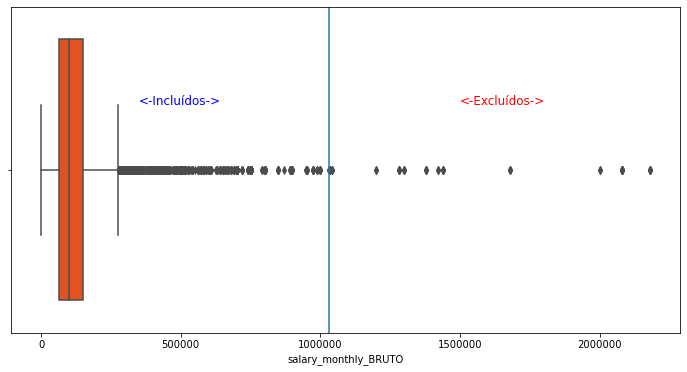

In [7]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_lang, x='salary_monthly_BRUTO',color='orangered')
plt.axvline(1031254.375)
plt.text(350000,-0.2, '<-Incluídos->',size=12, color = 'blue')
plt.text(1500000,-0.2, '<-Excluídos->',size=12, color='red')
plt.ticklabel_format(style='plain', axis='x')

Generamos un nuevo dataframe "df_filtered", filtrando aquellos valores que estén por debajo de **30.000** y por encima de **1.031.254,375** en salario bruto. Para los valores que están por debajo del monto, buscamos incluir datos cercanos al salario mínimo y que se acerquen a una distribución normal en los histogramas de cada población.

In [8]:
minumum_salary=30000
maximum_salary=1031254.375
columna_salario = 'salary_monthly_BRUTO'

df_filtered = df_lang.loc[(df_lang[columna_salario] > minumum_salary) & (df_lang[columna_salario] < maximum_salary)].sort_values(by=columna_salario, ascending=False).reset_index(drop=True)

pop_mean = df_filtered[columna_salario].mean()
pop_median = df_filtered[columna_salario].median()
df_greater_pop_mean = df_filtered[df_filtered[columna_salario] > pop_mean]
prob_greater_pop_mean = len(df_greater_pop_mean) / len(df_filtered)

## Generación dataset final

Iteramos sobre **df_filtered** para hacer los análisis sobre las distintas poblaciones de lenguages. Nos interesan los lenguages con mas de 50 programadores, ya que consideramos que tienen un espacio de muestra que exhiben una conclusión representativa. Se termina con **df_final_metrics** que tiene toda la estadística descriptiva para responder a las preguntas del ejercicio.

In [9]:
list_of_languages = df_filtered['programming_language'].unique()

df_columns = ['Language','n_programmers','subpop_Salary_mean','subpop_Salary_median','subpop_Central_Diff','within_subpop_>avg','conditional_prob','pop_prob','cond_ratio','pop_mean']
df_final_metrics = pd.DataFrame(columns= df_columns)
data = []

number_of_programmers_cutoff = 50

for item in list_of_languages:
  
    selected_language_dataframe = df_filtered[df_filtered['programming_language'] == item]
    subpop_programmers_number = len(selected_language_dataframe)

    if subpop_programmers_number > number_of_programmers_cutoff:

        subpop_mean = round(selected_language_dataframe[columna_salario].mean(),2)
        subpop_median = round(selected_language_dataframe[columna_salario].median(),2)
        subpop_above_mean_prob = len(selected_language_dataframe[selected_language_dataframe[columna_salario] > subpop_mean]) / len(selected_language_dataframe)
        subpop_central_diff = subpop_mean - subpop_median
        df_within_subpop_above_avg_salary = selected_language_dataframe[selected_language_dataframe[columna_salario] > subpop_mean]
        prob_within_subpop_above_avg_salary = len(df_within_subpop_above_avg_salary) / len(selected_language_dataframe)

        df_intersection =  (df_lang.programming_language == item) & (df_lang.salary_monthly_BRUTO > pop_mean)
        conditional_prob = sum(df_intersection) / len(selected_language_dataframe)
        subpop_pop_cond_ratio = conditional_prob/prob_greater_pop_mean

        values = [item,subpop_programmers_number,subpop_mean,subpop_median,subpop_central_diff,round(prob_within_subpop_above_avg_salary,2),round(conditional_prob,2),round(prob_greater_pop_mean,2),round(subpop_pop_cond_ratio,2),round(pop_mean,2)]
        zipped = zip(df_columns, values)
        a_dictionary = dict(zipped)
        data.append(a_dictionary)

df_final_metrics = df_final_metrics.append(data, True)
df_final_metrics = df_final_metrics.sort_values('cond_ratio', ascending=True).reset_index(drop=True)

In [10]:
df_final_metrics.sort_values('cond_ratio', ascending=False)

,Language,n_programmers,subpop_Salary_mean,subpop_Salary_median,subpop_Central_Diff,within_subpop_>avg,conditional_prob,pop_prob,cond_ratio,pop_mean
24,scala,111,215080.60,180266.0,34814.60,0.35,0.71,0.33,2.14,135041.36
23,go,294,200392.67,161500.0,38892.67,0.31,0.64,0.33,1.91,135041.36
22,kotlin,182,176433.76,150000.0,26433.76,0.37,0.60,0.33,1.82,135041.36
21,ruby,145,219022.81,150000.0,69022.81,0.32,0.56,0.33,1.68,135041.36
20,swift,100,184244.00,142500.0,41744.00,0.33,0.54,0.33,1.62,135041.36
19,groovy,162,158416.71,136500.0,21916.71,0.38,0.51,0.33,1.54,135041.36
18,cobol,79,142121.52,120000.0,22121.52,0.35,0.43,0.33,1.29,135041.36
17,java,1385,138683.26,119000.0,19683.26,0.39,0.40,0.33,1.19,135041.36
16,python,1418,147065.22,118168.5,28896.72,0.34,0.39,0.33,1.17,135041.36
15,bash/shell,957,144461.49,120000.0,24461.49,0.34,0.38,0.33,1.15,135041.36


In [11]:
df_final_metrics.sort_values('n_programmers', ascending=False)

,Language,n_programmers,subpop_Salary_mean,subpop_Salary_median,subpop_Central_Diff,within_subpop_>avg,conditional_prob,pop_prob,cond_ratio,pop_mean
12,javascript,2369,132952.99,101000.0,31952.99,0.34,0.33,0.33,0.98,135041.36
7,sql,2031,123228.64,100000.0,23228.64,0.35,0.28,0.33,0.85,135041.36
1,html,1736,122575.32,94000.0,28575.32,0.32,0.27,0.33,0.80,135041.36
16,python,1418,147065.22,118168.5,28896.72,0.34,0.39,0.33,1.17,135041.36
17,java,1385,138683.26,119000.0,19683.26,0.39,0.40,0.33,1.19,135041.36
4,css,1164,122192.44,93750.0,28442.44,0.33,0.27,0.33,0.82,135041.36
15,bash/shell,957,144461.49,120000.0,24461.49,0.34,0.38,0.33,1.15,135041.36
8,php,826,126107.68,96435.0,29672.68,0.33,0.29,0.33,0.87,135041.36
6,.net,770,122484.99,99172.5,23312.49,0.34,0.28,0.33,0.85,135041.36
14,typescript,740,146859.65,114448.5,32411.15,0.33,0.38,0.33,1.14,135041.36


El siguiente gráfico permite determinar el Top 3 de lenguajes de programación asociados a una mayor probabilidad de percibir un mejor salario. El parámetro cuantitativo utilizado es el Ratio entre la probabilidad condicional de ganar salarios por encima de la media de cada subpoblación de lenguajes y la probabilidad de ganar por sobre la media en la población global de programadores. Ese valor se denomina AAR (Above Average Ratio), y funciona con mayor poder descriptivo que la Media, dado que está basado en probabilidades.

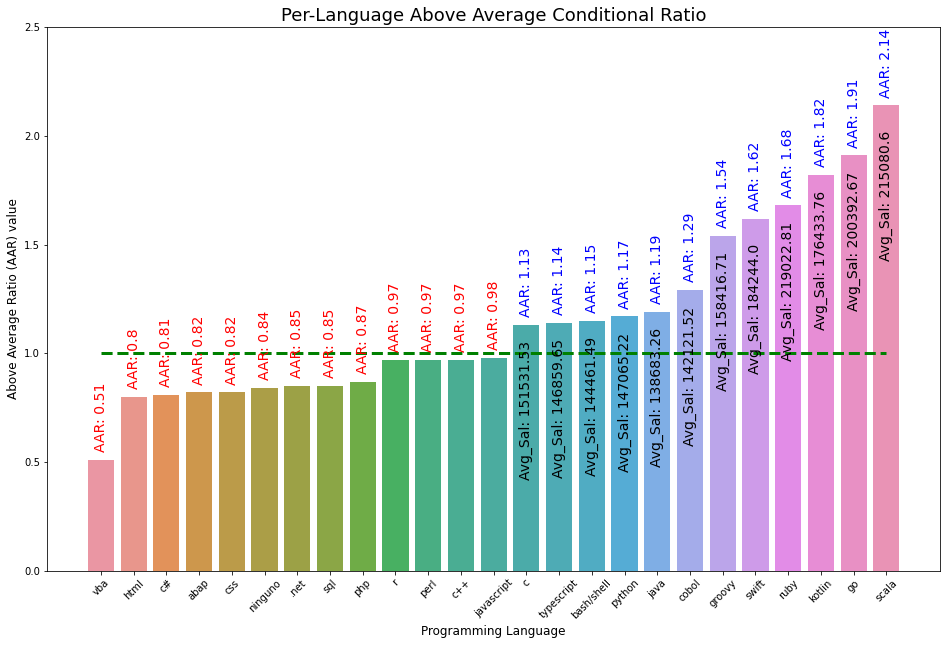

In [12]:
fig = plt.figure(figsize=(16,10))
ax = sns.barplot(x=df_final_metrics.Language, y=df_final_metrics.cond_ratio, data=df_final_metrics)
ax = sns.lineplot(x=df_final_metrics.Language, y=1.0, data=df_final_metrics, linestyle='dashed',linewidth=3,color='green')
plt.xticks(rotation=45)
plt.ylim([0,2.5])
plt.xlabel('Programming Language',size=12)
plt.ylabel('Above Average Ratio (AAR) value',size=12)
plt.title('Per-Language Above Average Conditional Ratio', size=18)

for lang,mean,ratio in zip(df_final_metrics.Language,df_final_metrics.subpop_Salary_mean,df_final_metrics.cond_ratio):
    if ratio > 1:
        ax.text(lang,ratio+0.05,'AAR: {}'.format(ratio),size=14,color='blue',ha='center',rotation=90)
        ax.text(lang,ratio-0.7,'Avg_Sal: {}'.format(mean),size=14,color='black',ha='center',rotation=90)
    if ratio <= 1:
        ax.text(lang,ratio+0.05,'AAR: {}'.format(ratio),size=14,color='red',ha='center',rotation=90)

Conociendo los 12 lenguages que tienen un AAR mayor a 1, tiene sentido ver un histograma de la distribución de salarios para cada subpoblación y visualizar que no hay datos atípicos mas allá de la ligera asimetría hacia salarios mas altos.

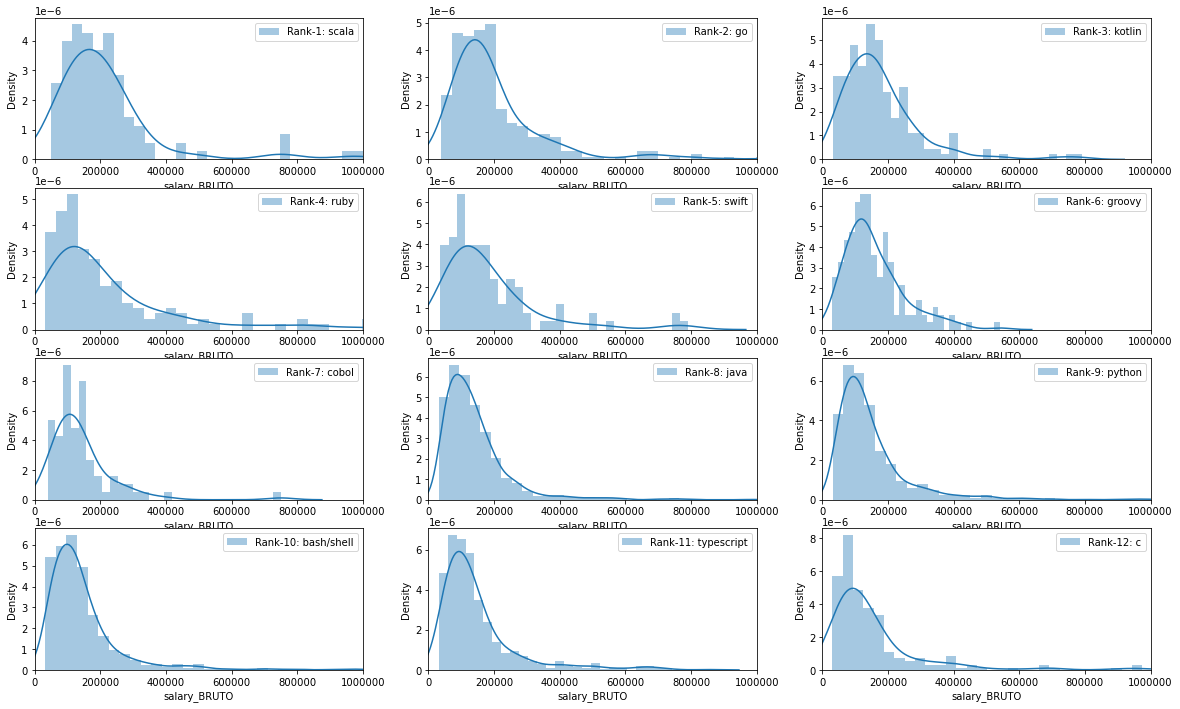

In [13]:
items_altos = df_final_metrics[-12:].Language.iloc[::-1] 
fig = plt.subplots(figsize=(20,12))

for index, item in enumerate(items_altos):
    plt.subplot(4, 3, index + 1)
    df_analysis = df_filtered[df_filtered['programming_language'] == item]
    sns.distplot(x=df_analysis['salary_monthly_BRUTO'],bins=30,label='Rank-{}: {}'.format(index+1,item))
    plt.xlim([0,1000000])
    plt.xlabel('salary_BRUTO')
    plt.ticklabel_format(style='plain', axis='x')
    plt.legend()


# ¿Cuáles son los lenguajes de programación asociados a los mejores salarios?

Luego del análisis realizado y basandonos en el **AAR (Above Average Ratio)** calculado, podemos concluir que los lenguajes de programación asociados a los mejores salarios son, de mayor a menor:
- Scala
- Go
- Kotlin

# Ejercicio 2 - Densidades y varias variables

Responder a la pregunta general: **¿Que herramientas (prácticas y teóricas) són útiles para explorar la base, descubrir patrones, asociaciones?**

Para ello considere (igual al ejercicio Anterior):
1. Seleccionar las columnas relevantes para analizar.
2. Seleccionar las filas relevantes para analizar. Esto incluye la eliminación de valores extremos y erróneos, pero también puede enfocar el análisis en sub-poblaciones. 

Decidimos quedarnos con las variables que vamos a utilizar en este segundo ejercicio, para hacer una limpieza rápida de las mismas, y luego utilizar este dataset como base para los próximos cálculos.

In [14]:
columns = ['profile_age', 'profile_years_experience', 'work_people_in_charge_of', 'profile_gender','work_has_violence_situations','salary_monthly_BRUTO', 'salary_monthly_NETO','profile_studies_level']
df[columns].describe().round()

,profile_age,profile_years_experience,work_people_in_charge_of,salary_monthly_BRUTO,salary_monthly_NETO
count,6095.0,6095.0,6095.0,6095.0,5883.0
mean,41.0,9.0,2.0,124059.0,94908.0
std,666.0,7.0,33.0,122912.0,96862.0
min,18.0,0.0,0.0,1.0,1.0
25%,27.0,3.0,0.0,61595.0,51480.0
50%,31.0,7.0,0.0,96000.0,78000.0
75%,37.0,13.0,0.0,145000.0,106000.0
max,52000.0,115.0,2500.0,2180000.0,2080000.0


Viendo las columnas numéricas, vemos que existen outliers en:
- 'profile_age': Hay una edad de 52000, lo cual indica que hay **al menos** 1 registro incorrecto. Ponemos un tope a esta columna en 100 (años) por un sentido biológico.
- 'profile_years_experience': Vemos que existe un registro en 115 (años), lo cual tampoco tiene sentido considerando el corte 'profile_age' a 100 años. Para ser consistentes filtramos esta columna también en 100 años.
- 'work_people_in_charge_of': Existe un registro de 2500, por lo tanto lo eliminamos de la muestra por considerarlo **dato atípico**. 
- Salarios: usamos la misma estrategia que antes, nos quedamos con los sueldos netos comprendidos entre \\$30000 y \\$1031254,37.

Una vez identificados los filtros, generamos un nuevo dataset (df_2) aplicando los filtros antes mencionados para quedarnos con un dataset limpio.

In [15]:
minumum_salary=30000
maximum_salary=1031254.375
columna_salario = 'salary_monthly_NETO'
df_2 = df[columns]
df_2 = df_2[df_2.profile_age < 100]
df_2 = df_2[df_2.work_people_in_charge_of < 2500]
df_2 = df_2[df_2.profile_years_experience < 100]
df_2 = df_2[(df_2[columna_salario] > minumum_salary) & (df_2[columna_salario] < maximum_salary)]
df_2.head()

,profile_age,profile_years_experience,work_people_in_charge_of,profile_gender,work_has_violence_situations,salary_monthly_BRUTO,salary_monthly_NETO,profile_studies_level
0,26,3.0,0,Mujer,En mi trabajo actual,53000.0,43000.0,Universitario
1,29,5.0,4,Hombre,Jamás,79000.0,63000.0,Universitario
2,22,2.0,0,Mujer,En un trabajo anterior,160000.0,127000.0,Secundario
3,39,15.0,5,Hombre,En mi trabajo actual,130000.0,102000.0,Posgrado
4,32,9.0,0,Hombre,Jamás,140000.0,106000.0,Universitario


## a) Densidad conjunta

Que herramientas visuales y modelos puede utilizar para estudiar la distribución y comportamiento de sus datos? 

<font color='blue'> - Dado un conjunto de datos a analizar, la primera exploración visual resulta importante a los fines de conocer la distribución de los datos. Para ello utilizaríamos una serie de histogramas, si es que se desea hacer análisis por subconjuntos (como en el ejemplo de las celdas de arriba), y un histograma general si se quiere analizar el comportamiento de todos los datos juntos. Luego si se quiere profundizar sobre alguna población general de datos se pueden analizar diagramas del tipo 'boxplot' para evaluar la distribución de los datos. </font>

Elija tres variables numéricas y 2 variables categóricas. Visualice la base según varias de las variables elegidas. Puede describir de alguna forma el comportamiento de sus datos? Que herramientas utilizaría? Describa


<font color='blue'> Existen variables numéricas, tales como: 1.1- Edad ('profile_age'), 1.2-Años de Experiencia ('profile_years_experience') y 1.3-Personal a cargo ('work_people_in_charge_of'). Por otra parte tenemos variables categóricas, tales como: 2.1-Género ('profile_gender') y 2.2-Declara violencia laboral ('work_has_violence_situations').</font>

In [16]:
columns = ['profile_age', 'profile_years_experience', 'work_people_in_charge_of', 'profile_gender', 'work_has_violence_situations']
df_a = df_2[columns]
df_a.head()

,profile_age,profile_years_experience,work_people_in_charge_of,profile_gender,work_has_violence_situations
0,26,3.0,0,Mujer,En mi trabajo actual
1,29,5.0,4,Hombre,Jamás
2,22,2.0,0,Mujer,En un trabajo anterior
3,39,15.0,5,Hombre,En mi trabajo actual
4,32,9.0,0,Hombre,Jamás


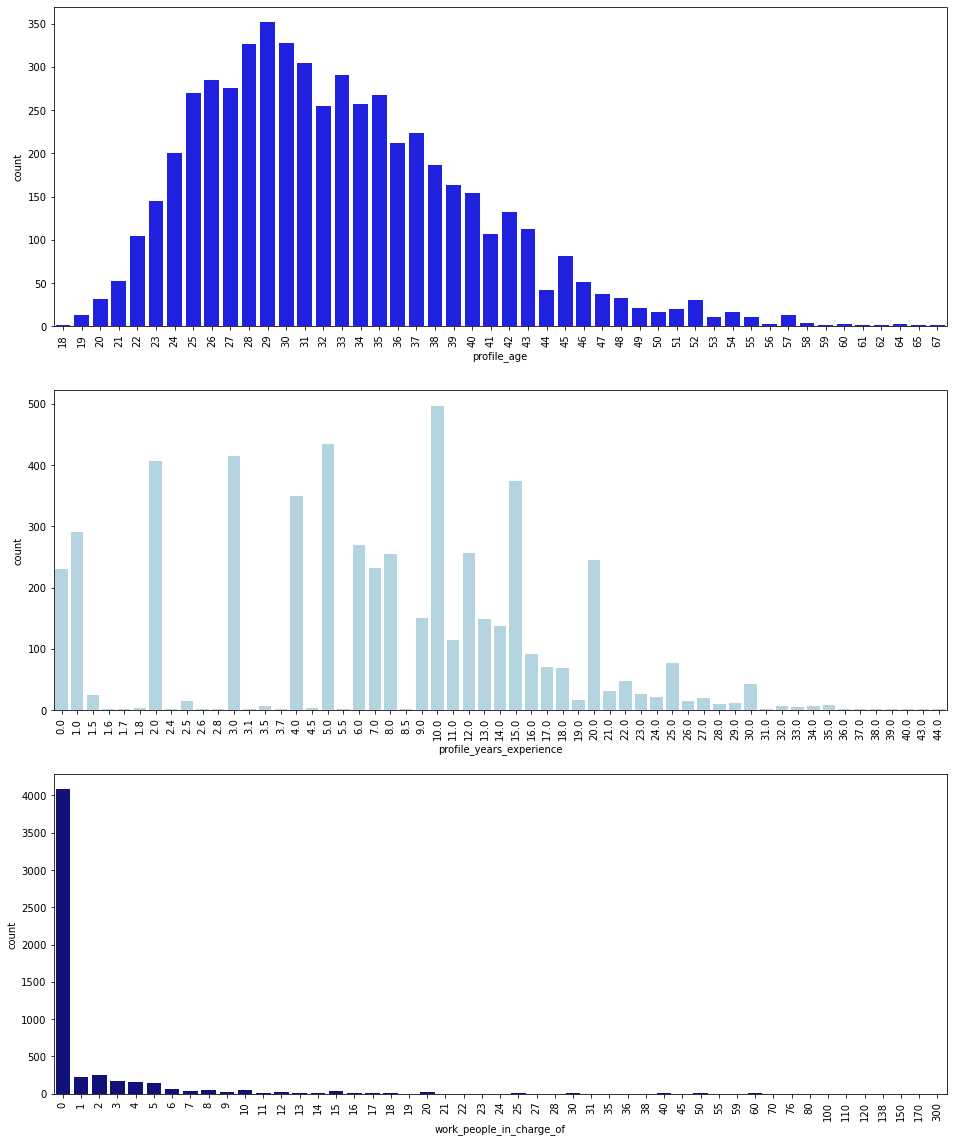

In [17]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(16,20))
sns.countplot(df_a['profile_age'], ax=ax[0], color = 'blue')
sns.countplot(df_a['profile_years_experience'], ax=ax[1], color = 'lightblue')
sns.countplot(df_a['work_people_in_charge_of'], ax=ax[2], color = 'darkblue')
ax[0].tick_params(axis='x', rotation=90)
ax[1].tick_params(axis='x', rotation=90)
ax[2].tick_params(axis='x', rotation=90)

El análisis de la base empleando variables numéricas indica: 
- En relación a la Edad, se observa una distribución normal de la edad de los programadores, comprendiendo un universo de entre 18 y 67 años. Claramente los programadores entre 25-35 años son los más numerosos.
- En relación a los años de experiencia, se observa una distribución aleatoria, con personal de 10 años de experiencia siendo el más numeroso.
- En relación a la consulta de personas a cargo, claramente la gran mayoría de personas trabajan sin (0) personas a cargo. El trabajo con personal a cargo parece ser mas escaso, disminuyendo con la cantidad de personas dependientes.

<AxesSubplot:xlabel='work_has_violence_situations', ylabel='count'>

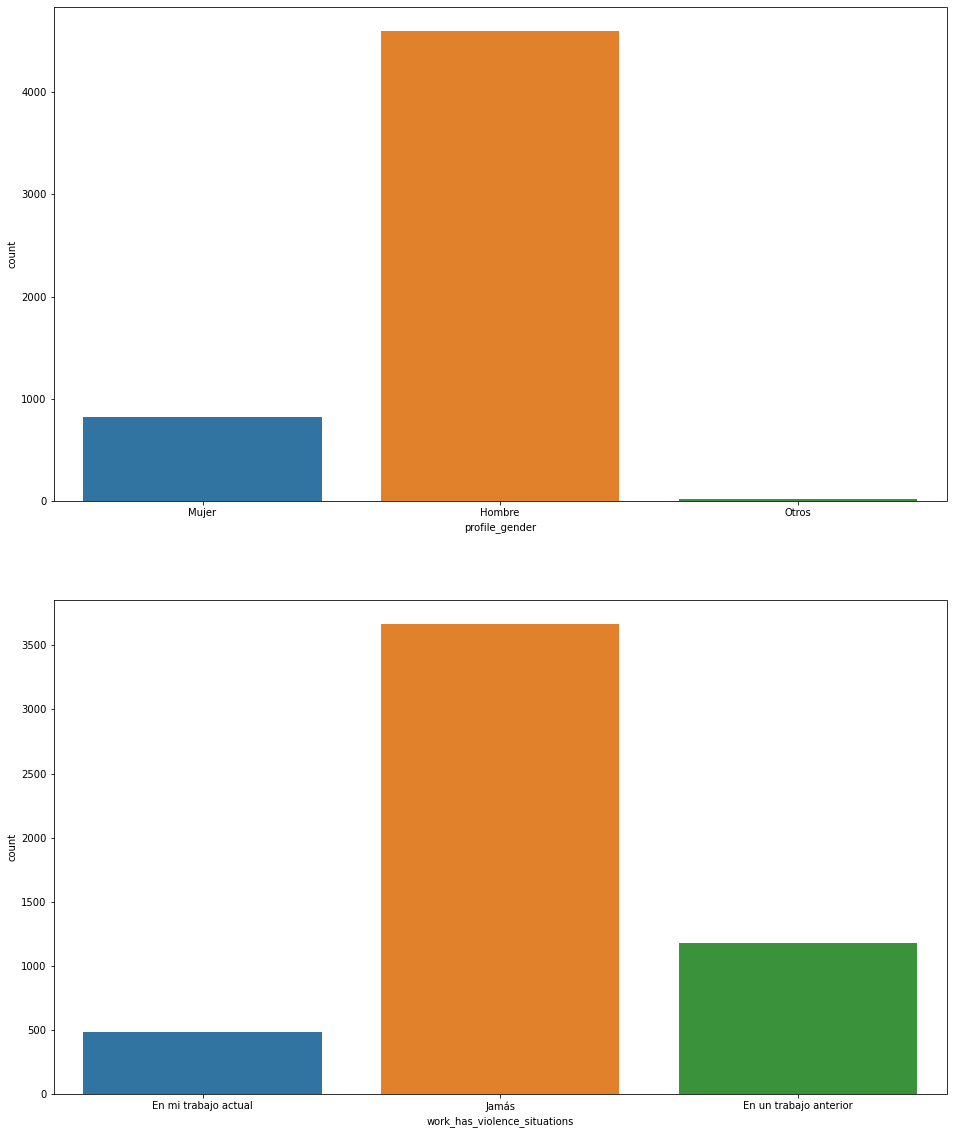

In [18]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16,20))
sns.countplot(df_a['profile_gender'], ax=ax[0])
sns.countplot(df_a['work_has_violence_situations'], ax=ax[1], )

Mediante el análisis de la base por algunas variables categóricas, se observa que:
- La mayoría que respondió la encuesta son hombres.
- La mayoría nunca ha tenido situaciones violencia laboral.

## b) Asociación

* Necesitamos decidir si sacar o no la columna de salario bruto. Para hacer la encuesta más simple.
¿Existe una correlación entre el salario bruto y el neto? Que abordaje y medidas usaría



Como primer hipótesis, dado que amban variables estan relacionadas por el hecho de que el salario neto es el salario bruto menos los aportes y deducciones que tenga, es altamente probable que ambas variables tengan una alta correlación, **a no se que existan diferencias cualititivas en la forma que se aplican retenciones al personal**. Para hacer un análisis simple, vamos a ver una matriz de correlación para intentar aclarar un poco y deducir si hay o no correlación.

<AxesSubplot:>

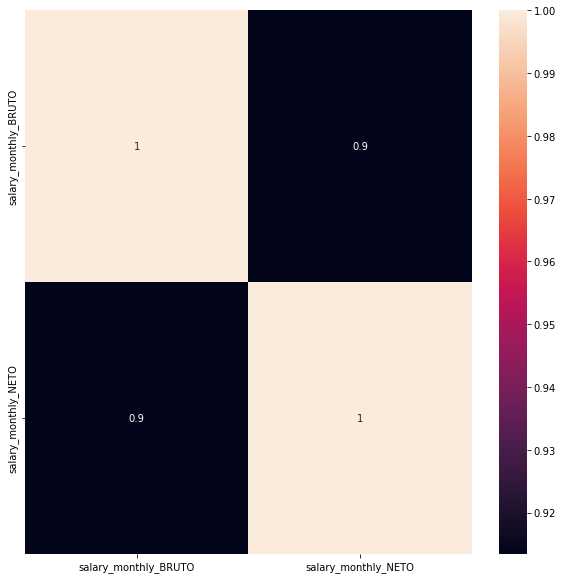

In [19]:
corr = df_filtered[['salary_monthly_BRUTO', 'salary_monthly_NETO']].corr()
fig = plt.figure(figsize=(10,10))
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True, fmt='.1g')


El primer análisis cuantitativo indica que el salario BRUTO y NETO **tienen una correlación positiva de 0.9**, lo cual es considerado alto. Ello sugiere que que si existe correlación, habilitando la posiblidad de simplificar la encuesta quitando el salario BRUTO y basar los análisis posteriore solo al salario NETO. Una pregunta posterior sería: ¿Cual de los dos salarios conviene quitar?: Para dar respuesta a ello analizamos la cantidad de valores faltantes en cada columna.

In [20]:
na_ratio = ((df_filtered[['salary_monthly_BRUTO','salary_monthly_NETO']].isnull().sum() / len(df))*100).sort_values(ascending = False)
print(na_ratio)

salary_monthly_NETO     9.942576
salary_monthly_BRUTO    0.000000
dtype: float64


In [21]:
df_filtered[['salary_monthly_BRUTO','salary_monthly_NETO']].describe().round()

,salary_monthly_BRUTO,salary_monthly_NETO
count,16968.0,16362.0
mean,135041.0,102452.0
std,109890.0,88202.0
min,30250.0,13.0
25%,70000.0,57405.0
50%,104812.0,82000.0
75%,159000.0,113000.0
max,1031250.0,1600000.0


Analizando un poco más los datos descriptivos de cada variable, vemos que el Salario Bruto tiene más coherencia en sus datos, por ejemplo el valor mínimo se encuentra en \\$30250 cuando en el Salario Neto se encuentra en $13 (claramente esto es un error de tipeo y es un outlier, por lo tanto deberia ser removido). 

In [22]:
print("Coeficiente de variación salario bruto: ",
      scipy.stats.variation(df_filtered.salary_monthly_BRUTO))
print("Coeficiente de variación salario neto: ",
      scipy.stats.variation(df_filtered.salary_monthly_NETO.dropna()))

Coeficiente de variación salario bruto:  0.8137261396184972
Coeficiente de variación salario neto:  0.8608851363387606


Viendo un poco el coeficiente de variación de cada variable, tenemos más argumentos para quedarnos con el Salario Bruto, ya que en resumen:
- No tiene valores faltantes.
- Los datos son más homogeneos.
- Tiene un menor coeficiente de variación.

En este punto **volvemos a desafiar la hipótesis de eliminar una de las dos columnas de salario**, analizando la posibilidad de que por debado de la correlación 0.9 antes mencionada existan eventos particulares.


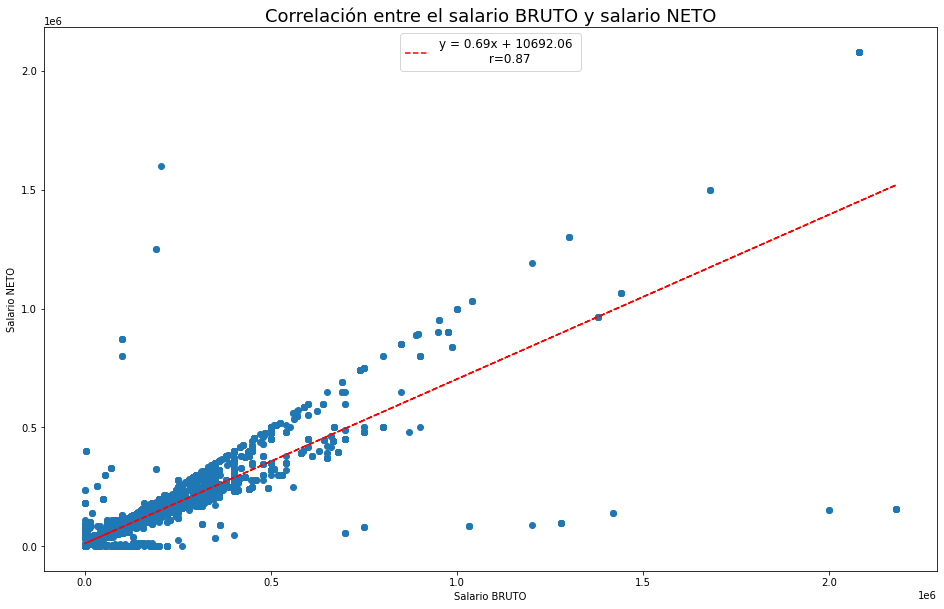

In [23]:
# Quitamos las rows sin dato de NETO
df2 = df_lang[df_lang['salary_monthly_NETO'].notna()]

fig = plt.figure(figsize=(16,10))
plt.scatter(df2['salary_monthly_BRUTO'],df2['salary_monthly_NETO'])

slope, intercept, r_value, p_value, std_err = stats.linregress(df2['salary_monthly_BRUTO'],df2['salary_monthly_NETO'])

# Calcula la pendiente y ordenada al origen y ploteo la regresión
b, m = np.polyfit(df2['salary_monthly_BRUTO'],df2['salary_monthly_NETO'].dropna(), deg=1)
plt.plot(df2['salary_monthly_BRUTO'], m + b * df2['salary_monthly_BRUTO'] , '--', color='red', label='y = {:.2f}x + {:.2f} \n r={:.2f}'.format(slope,intercept,r_value)) 


plt.title("Correlación entre el salario BRUTO y salario NETO", size=18)
plt.xlabel("Salario BRUTO")
plt.ylabel("Salario NETO")
legend=plt.legend(fontsize=12, loc=9)
for t in legend.get_texts():
   t.set_ha('center')

Del análisis visual de la base completa mediante un SCATTERPLOT, **se observa un valor de coeficiente de correlación que sugiere correlación de datos (r=0.87), pero el análisis visual demuestra que dicho r está originado en una compensación de residuales de ajuste**. Si se observan que hay subgrupos de correlaciones lineales con distintas pendientes, lo cual en el contexto del dominio de los datos se interpreta como que **hay distintas poblaciones con configuraciones impositivas diferentes**, que llevan entonces a las distintas pendientes (y porcentajes de deducciones sobre el BRUTO).
En este contexto, si bien la correlación lineal entre todos los datos es alta, **es riesgoso asumir que existe correlación total entre el salario BRUTO y el salario NETO**, por lo que no sacaríamos la columna del sueldo BRUTO. En el caso de utilizar el suelto NETO para elaborar las conclusiones, habría que verificar de no introducir un error al considerar que la población tiene un esquema de deducciones impositivas homogéneo. En tal caso sería necesario aplicar algun método analítico para separar la muestras por distintos grupos de correlación BRUTO vs NETO, y luego los análisis estarían confinados a cada subgrupo en particular.

## c) Densidad condicional 

Estudie la distribución del salario según el nivel de estudio.

Separe la población según el nivel de estudio (elija dos subpoblaciones numerosas) y grafique de manera comparativa ambos histogramas de la variable `'salary_monthly_NETO'`
¿Considera que ambas variables son independientes?
¿Qué analizaría al respecto?

Calcule medidas de centralización y dispersión para cada subpoblación






In [24]:
columnas_c = ['profile_studies_level', 'salary_monthly_BRUTO']
df_c = df_2[columnas_c]
df_c.head()

,profile_studies_level,salary_monthly_BRUTO
0,Universitario,53000.0
1,Universitario,79000.0
2,Secundario,160000.0
3,Posgrado,130000.0
4,Universitario,140000.0


Para poder elegir dos subpoblaciones numerosas, vemos el value_counts de la variable "profile_studies_level" y asi elegir las dos que más registros tienen.

In [25]:
df_c.profile_studies_level.value_counts()

Universitario    3714
Terciario        1017
Secundario        388
Posgrado          302
Doctorado          24
Posdoctorado        3
Primario            2
Name: profile_studies_level, dtype: int64

Vemos que **las dos variables con más registros son "Universitario" y "Terciario"**, por lo tanto creamos un nuevo dataframe únicamente con estos registros, para luego poder analizarlos gráficamente. También aplicamos el mismo filtro que usamos en el primer ejercicio, para quedarnos únicamente con los sueldos mayores a \\$30000 y menores a \\$1031254,375.

In [26]:
filtro = ['Universitario','Terciario']
df_c_filtered = df_c[(df_c.profile_studies_level.isin(filtro))]
df_c_filtered.profile_studies_level.value_counts()

Universitario    3714
Terciario        1017
Name: profile_studies_level, dtype: int64

In [27]:
df_c.describe().round()

,salary_monthly_BRUTO
count,5450.0
mean,127401.0
std,113637.0
min,1.0
25%,67000.0
50%,100000.0
75%,148000.0
max,2180000.0


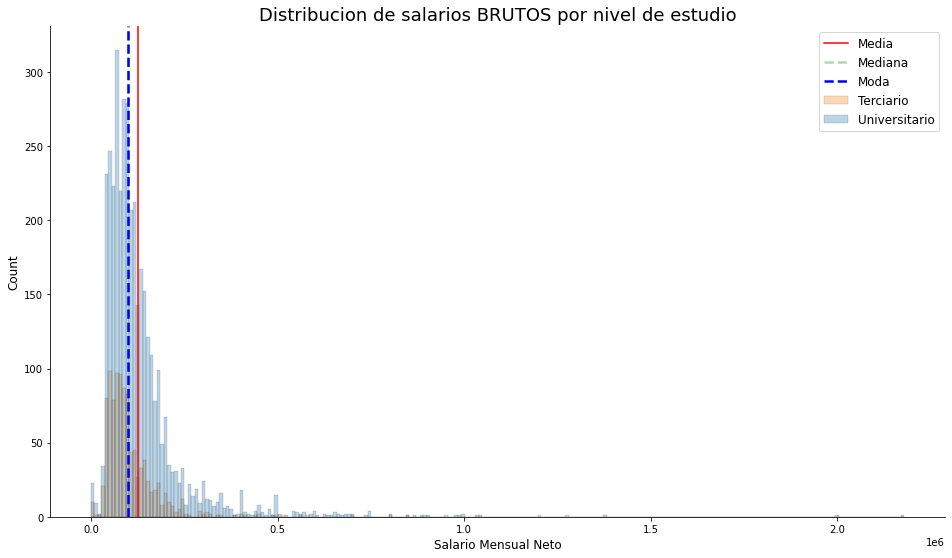

In [28]:
ax = sns.displot(df_c_filtered, x='salary_monthly_BRUTO', hue='profile_studies_level', kind='hist', alpha=0.3, legend=False)
plt.axvline(x=df_c_filtered.salary_monthly_BRUTO.mean(),
            color='red')
plt.axvline(x=df_c_filtered.salary_monthly_BRUTO.median(),
            color='green',
            ls='--', 
            lw=2.5, alpha=0.3)
plt.axvline(x=df_c_filtered.salary_monthly_BRUTO.mode()[0],
            color='blue',
            ls='--', 
            lw=2.5)
plt.xlabel('Salario Mensual Neto',size=12)
plt.ylabel('Count',size=12)
plt.title('Distribucion de salarios BRUTOS por nivel de estudio', size=18)
plt.gcf().set_size_inches(15, 8)
plt.legend(loc='upper right', labels=['Media', 'Mediana','Moda', 'Terciario', 'Universitario'], fontsize='large')
plt.show(fig)

Mediante análisis cualitativo de los histogramas de ambas poblaciones (Universitaria  y Terciaria), **se observa una dispersión de datos hacia sueldos mas altos**. Eso significa que vale la pena analizar estadísticamente si es que los estudios Universitarios dan mas probabilidad de ganar mas dinero.

In [29]:
for i in set(df_c_filtered.profile_studies_level):
    std = str(format(df_c_filtered[df_c_filtered.profile_studies_level == i]['salary_monthly_BRUTO'].std(),".2f"))
    var = str(format(df_c_filtered[df_c_filtered.profile_studies_level == i]['salary_monthly_BRUTO'].var(),".2f"))
    coef_var = str(format(scipy.stats.variation(df_c_filtered[df_c_filtered.profile_studies_level == i]['salary_monthly_BRUTO'].dropna()),".2f"))
    mean = str(format(df_c_filtered[df_c_filtered.profile_studies_level == i]['salary_monthly_BRUTO'].mean(),".2f"))
    median = str(df_c_filtered[df_c_filtered.profile_studies_level == i]['salary_monthly_BRUTO'].median())
    mode = str(df_c_filtered[df_c_filtered.profile_studies_level == i]['salary_monthly_BRUTO'].mode()[0])
    print("Medidas de dispersión - Nivel de estudio: "+i)
    print("Desvío estándar: "+std)
    print("Varianza: "+var)
    print("Coeficiente de variación: "+coef_var)
    print("Medidas de centralización - Nivel de estudio: "+i)
    print("Media: "+mean)
    print("Mediana: "+median)
    print("Moda: "+mode)
    print("\n")
    

Medidas de dispersión - Nivel de estudio: Universitario
Desvío estándar: 116721.06
Varianza: 13623806921.26
Coeficiente de variación: 0.89
Medidas de centralización - Nivel de estudio: Universitario
Media: 130994.64
Mediana: 101750.0
Moda: 100000.0


Medidas de dispersión - Nivel de estudio: Terciario
Desvío estándar: 95655.94
Varianza: 9150058210.89
Coeficiente de variación: 0.88
Medidas de centralización - Nivel de estudio: Terciario
Media: 108224.79
Mediana: 86000.0
Moda: 100000.0




## d) Densidad Conjunta condicional

Elija dos variables numéricas y una categórica. 
Estudie la dispersión (scatterplot) de las dos variables discriminando en color por la variable categórica (ayuda: hue en seaborn)


In [30]:
columnas = ['profile_gender', 'salary_monthly_BRUTO', 'profile_age']
df_d = df_2[columnas]
df_d.head()

,profile_gender,salary_monthly_BRUTO,profile_age
0,Mujer,53000.0,26
1,Hombre,79000.0,29
2,Mujer,160000.0,22
3,Hombre,130000.0,39
4,Hombre,140000.0,32


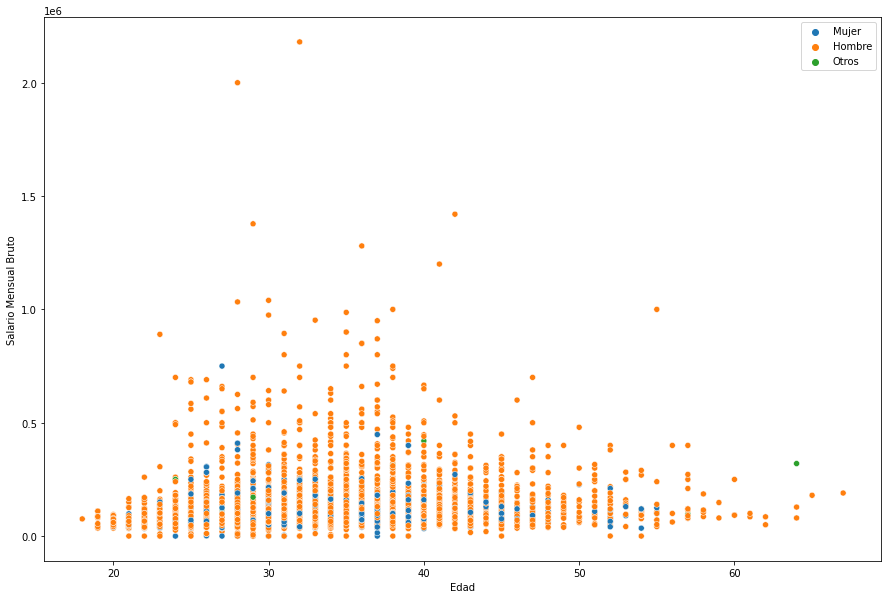

In [31]:
fig = plt.figure(figsize=(15,10))
sns.scatterplot(data=df_d, x="profile_age", y="salary_monthly_BRUTO", hue="profile_gender")
plt.xlabel('Edad')
plt.ylabel('Salario Mensual Bruto')
plt.legend()

El gráfico sugiere que **la dispersión de sueldos brutos hacia valores más altos se da en la población de entre 25-35 años**. También se observa que valores mas altos son más frecuentes en hombres que en mujeres. Por último, a medida que el programador pertenece a rangos etarios hacia los extremos del rango 25-35 años la dispersión hacia salarios mas altos se reduce.

# Trabajo práctico entregable - Parte 2

## Lectura del dataset

En la notebook 00 se explican los detalles de la siguiente sección.

In [32]:
url = 'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/sysarmy_survey_2020_processed.csv'
df = pd.read_csv(url)


In [33]:
df[:3]

,profile_gender,profile_age,work_country,work_province,profile_years_experience,work_years_in_company,work_years_in_current_position,work_people_in_charge_of,profile_studies_level,profile_studies_level_state,...,work_has_violence_situations,profile_sexual_orientation,profile_has_disabilities,profile_has_disabilities_hiring_difficulties,company_employee_number,company_main_activity,company_recommended,company_diversity_policies,company_extra_benefits,company_best_companies_city
0,Mujer,26,Argentina,Ciudad Autónoma de Buenos Aires,3.0,3.0,3.0,0,Universitario,En curso,...,En mi trabajo actual,Homosexual,NaN,NaN,501-1000,Servicios / Consultoría de Software / Digital,7,2,"Capacitaciones y/o cursos, Comidas pagas / sub...",NaN
1,Hombre,29,Argentina,Corrientes,5.0,2.0,2.0,4,Universitario,En curso,...,Jamás,Heterosexual,Visual,No,201-500,Otras industrias,8,9,"Horarios flexibles, Stock options / RSUs, Viát...",NaN
2,Mujer,22,Argentina,Ciudad Autónoma de Buenos Aires,2.0,0.0,0.0,0,Secundario,Completado,...,En un trabajo anterior,Bisexual o queer,NaN,No,2001-5000,Otras industrias,6,9,"Clases de gimnasia online, Comidas pagas / sub...",NaN


In [34]:
df[['profile_gender', 'salary_monthly_NETO']].groupby('profile_gender').describe()

salary_monthly_NETO                                     \
                             count          mean            std   min   
profile_gender                                                          
Hombre                      4944.0  98836.063558  102159.664237   1.0   
Mujer                        908.0  73501.414465   56256.880181   2.0   
Otros                         31.0  95441.354839   88635.674358  40.0   

                                                       
                    25%      50%       75%        max  
profile_gender                                         
Hombre          53285.0  80000.0  110000.0  2080000.0  
Mujer           43818.0  65000.0   92000.0   800000.0  
Otros           39500.0  74000.0  117500.0   380000.0

In [35]:
is_man = df.profile_gender == 'Hombre'

groupA = df[(df.salary_monthly_NETO > 1000) & is_man].salary_monthly_NETO
groupB = df[(df.salary_monthly_NETO > 1000) & ~is_man].salary_monthly_NETO


## Ejercicio 1: Estimación

**Consigna:**  Calcular una estimación puntual y un intervalo de confianza de nivel (1-alpha) para la resta entre la media del salario Neto para Hombres menos la media del salario Neto para otros géneros(diferencia de las medias entre el grupoA y grupoB). 
¿Cómo se relaciona este intervalo de confianza con el test de hipótesis?

### Análisis grupo A

In [36]:
groupA.describe().apply(lambda s: '{0:.2f}'.format(s))

count       4815.00
mean      101481.62
std       102215.30
min         1100.00
25%        55000.00
50%        80000.00
75%       110000.00
max      2080000.00
Name: salary_monthly_NETO, dtype: object

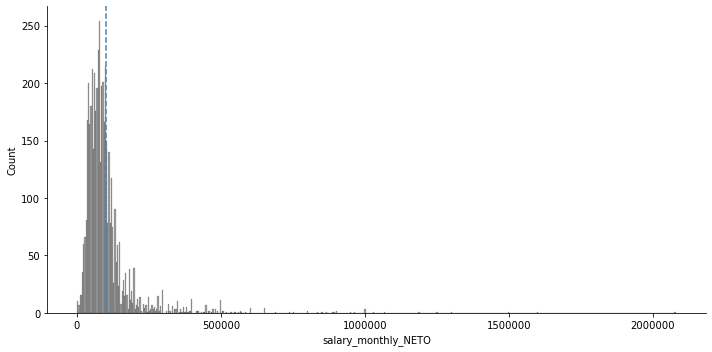

In [37]:
sns.displot(groupA, aspect=2, bins=500, color='gray') #cambiar los bins=5,20 0 50 y ver...
plt.ticklabel_format(style='plain', axis='x')
plt.axvline(groupA.mean(), color='steelblue',
            linestyle='--', label='Media')

In [38]:
lim_sup = 95
percentileA = groupA.quantile(lim_sup / 100)
n_below = len(groupA[groupA < percentileA])
print('Percentil {} de la columna {}: {}'.format(lim_sup, 'salary_monthly_NETO', percentileA))
print('Cantidad de datos menor que percentil {}: {}'.format(lim_sup, n_below ))
print('% de datos menor que percentil {}: {}'.format(lim_sup, n_below / len(groupA)))

Percentil 95 de la columna salary_monthly_NETO: 240000.0
Cantidad de datos menor que percentil 95: 4571
% de datos menor que percentil 95: 0.94932502596054


In [39]:
# Se eliminan los outliers por sobre percentil 95
groupA_aux = groupA[groupA < percentileA]
groupA_aux.describe().apply(lambda s: '{0:.2f}'.format(s))

count      4571.00
mean      83823.42
std       40408.16
min        1100.00
25%       54000.00
50%       79000.00
75%      105000.00
max      237500.00
Name: salary_monthly_NETO, dtype: object

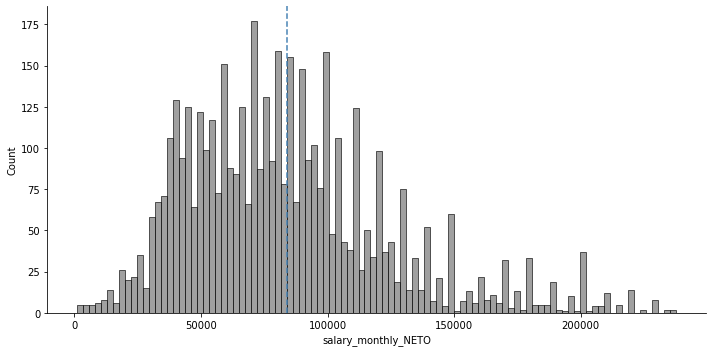

In [40]:
sns.displot(groupA_aux, aspect=2, bins=100, color='gray') #cambiar los bins=5,20 0 50 y ver...
plt.ticklabel_format(style='plain', axis='x')
plt.axvline(groupA_aux.mean(), color='steelblue',
            linestyle='--', label='Media')

### Análisis grupo B

In [41]:
groupB.describe().apply(lambda s: '{0:.2f}'.format(s))

count       891.00
mean      78219.25
std       56515.33
min        2000.00
25%       47600.00
50%       67310.00
75%       94000.00
max      800000.00
Name: salary_monthly_NETO, dtype: object

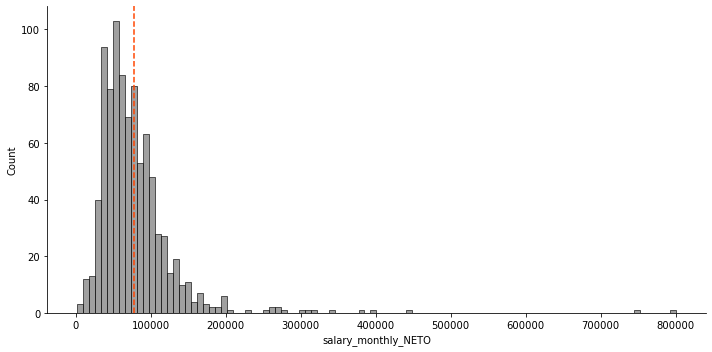

In [42]:
sns.displot(groupB, aspect=2, bins=100, color='gray') #cambiar los bins=5,20 0 50 y ver...
plt.ticklabel_format(style='plain', axis='x')
plt.axvline(groupB.mean(), color='orangered',
            linestyle='--', label='Media')

In [43]:
percentileB = groupB.quantile(lim_sup / 100)
n_below = len(groupB[groupB < percentileB])
print('Percentil {} de la columna {}: {}'.format(lim_sup, 'salary_monthly_NETO', percentileB))
print('Cantidad de datos menor que percentil {}: {}'.format(lim_sup, n_below ))
print('% de datos menor que percentil {}: {}'.format(lim_sup, n_below / len(groupB)))

Percentil 95 de la columna salary_monthly_NETO: 150000.0
Cantidad de datos menor que percentil 95: 841
% de datos menor que percentil 95: 0.9438832772166106


In [44]:
# Se eliminan los outliers por sobre percentil 95 para tener una mejor comparación visual.
groupB_aux = groupB[groupB < percentileB]
groupB_aux.describe().apply(lambda s: '{0:.2f}'.format(s))

count       841.00
mean      68983.57
std       28948.56
min        2000.00
25%       45000.00
50%       65000.00
75%       89788.00
max      149000.00
Name: salary_monthly_NETO, dtype: object

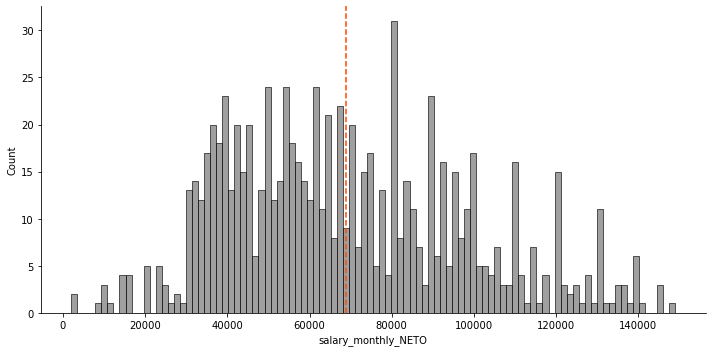

In [45]:
sns.displot(groupB_aux, aspect=2, bins=100, color='gray') #cambiar los bins=5,20 0 50 y ver...
plt.ticklabel_format(style='plain', axis='x')
plt.axvline(groupB_aux.mean(), color='orangered',
            linestyle='--', label='Media')

### Estimación Puntual

In [46]:
xA = round(groupA_aux.mean(), 2)
xB = round(groupB_aux.mean(), 2)
print("Media salario neto para Hombres: ", xA)
print("Media salario neto para Otros Géneros: ", xB)

mean_diff = round(xA - xB, 2);
print("Diferencia de las medias: ", mean_diff)

Media salario neto para Hombres:  83823.42
Media salario neto para Otros Géneros:  68983.57
Diferencia de las medias:  14839.85


### Intervalo del confianza del 95%

Procedimiento manual siguiendo bibligrafía tradicional, siendo que el tamaño de la muestra es $> 30$, podemos considerar que la media muestral tiene una distribución aproximadamente normal y también usar $s$ puntual como estimador de $\sigma$

$Z_{1-\frac{\alpha}{2}}$

In [47]:
alpha = 0.05
buscar = 1 - (alpha/2)
z = 1.96
print("Buscar en tabla z:", buscar)
print("z =", z)

Buscar en tabla z: 0.975
z = 1.96


In [48]:
# Estadísticos
nA = len(groupA_aux)
nB = len(groupB_aux)
print("nA =", nA)
print("nB =", nB)

sA = np.std(groupA_aux)
sB = np.std(groupB_aux)

print("Desvío estándar A: sA =", sA)
print("Desvío estándar B: sB =", sB)

s2A = np.var(groupA)
s2B = np.var(groupB_aux)

print("Varianza A: s =", s2A)
print("Varianza B: s =", s2B)

nA = 4571
nB = 841
Desvío estándar A: sA = 40403.74352981613
Desvío estándar B: sB = 28931.343511728086
Varianza A: s = 10445798632.500689
Varianza B: s = 837022637.3936108


In [49]:
# Término 1
term1 = (xA - xB)
# Término 2
term2 = z * np.sqrt((sA/nA) + (sB/nB))

li = round(term1 - term2, 2)
ls = round(term1 + term2, 2)

print("{} < u1 - u2 < {}".format(li, ls))

14826.96 < u1 - u2 < 14852.74


> **Con una probabilidad del 95% la diferencia de medias entre el Grupo A y B se encuentra entre 14826.96 y 14852.74**

Procedimiento con distribución $t$

In [50]:
nA = len(groupA_aux)
nB = len(groupB_aux)
print("nA =", nA)
print("nB =", nB)

xA = round(groupA_aux.mean(), 2)
xB = round(groupB_aux.mean(), 2)
print("Media salario neto para Hombres: ", xA)
print("Media salario neto para Otros Géneros: ", xB)

s2A = np.var(groupA_aux, ddof = 1)
s2B = np.var(groupB_aux, ddof = 1)

print("Varianza A: s =", s2A)
print("Varianza B: s =", s2B)

# Asumimos que la varianza es distinta en ambas poblaciones ya que si llevamos a cabo un cálculo
# de intervalo de confianza para diferencia de medias, suponiendo que las varianzas no son
# iguales, en el dado caso que sí lo fueran, perderíamos muy poco, y el intervalo obtenido sería
# un poco conservador. En el caso de que supongamos que las varianzas son iguales, siendo que no lo
# son, nos produce un error mayor que puede ser considerable por lo que una sugerencia es usar varianzas
# diferentes como regla general.

ratioA = s2A/nA
ratioB = s2B/nB
gdl = (ratioA + ratioB)**2 / (ratioA**2/(nA-1) + ratioB**2/(nB-1))
radius = ratioA + ratioB

# Buscamos el valor crítico
alpha = 0.05
crit_val = scipy.stats.t.ppf(q = 1-alpha/2, df = gdl)
print("Valor crítico: {}".format(crit_val))

# Find the lower and upper bound of the confidence interval
ls = (xA - xB) + crit_val*np.sqrt(radius)
li = (xA - xB) - crit_val*np.sqrt(radius)

print("{} < u1 - u2 < {}".format(round(li, 2), round(ls, 2)))

nA = 4571
nB = 841
Media salario neto para Hombres:  83823.42
Media salario neto para Otros Géneros:  68983.57
Varianza A: s = 1632819704.0221138
Varianza B: s = 838019092.9143175
Valor crítico: 1.961531662613035
12557.66 < u1 - u2 < 17122.04


> **Con una probabilidad del $95$% la diferencia de medias entre el Grupo A y B se encuentra entre $12557.66$ y $17122.04$**

### ¿Cómo se relaciona el cálculo del intervalo de confianza con el test de hipótesis?

> Probar una hipótesis $H_0$: $\mu = \mu_0$ contra $H_1$: $\mu \ne \mu_0$ en un nivel de significancia $\alpha$ es equivalente a calcular un intervalo de confianza del $100(1 - \alpha)$% de $\mu$ y rechazar $H_0$ si $\mu_0$ no está dentro del intervalo de confianza.

## Ejercicio 2: Test de hipótesis

### 2.1 Formalización

Describir formalmente los distintos componentes de un test de hipótesis para comprobar si la distribución de los salarios es distinta entre los grupos A y B.

**Hipótesis Nula**

$H_0$: $\mu_A - \mu_B = 0$

$H_0$ = "El salario del los hombres es igual al del resto de los grupos"

**Estadístico (Pivote)**

$t = \frac{(\overline{x}_A - \overline{x}_B) - (\mu_A - \mu_B)}{S_p\sqrt{\frac{1}{n_A} + \frac{1}{n_B}}}$
  
  * El estadístico a utilizar para desafiar la hipótesis nula es la media de los sueldos netos para el grupo A y el B. Hay que hacer un análisis de muestras no pareadas porque ambos grupos tienen distinto tamaño.
  
  * Se asume que los datos de salarios en ambas poblaciones tienen un distribución normal luego de eliminar los outliers.

(0.0, 250000.0)

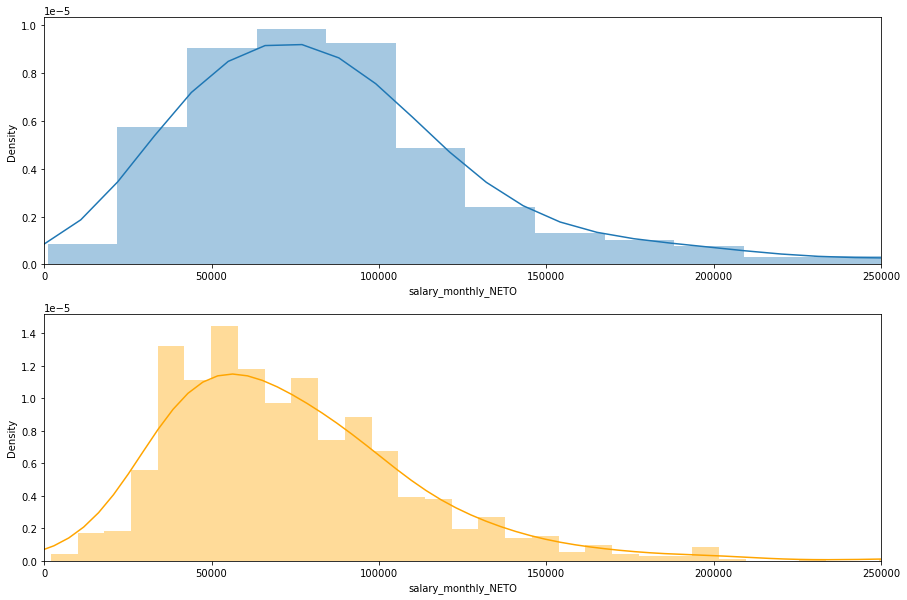

In [51]:
# Visualización de la distribución de los salarios en los dos grupos

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,10))
sns.distplot(groupA,ax=ax[0],bins=100)
ax[0].set_xlim(left=0, right=250000)
sns.distplot(groupB,ax=ax[1],color='orange',bins=100)
ax[1].set_xlim(left=0, right=250000)

### 2.2 P-valor

1. Calcule el p-valor y decida si rechazar o no la hipótesis nula.
2. Interprete el resultado.

Links útiles:
* [Test de hipótesis usando scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html)
* [Test de Welch](http://daniellakens.blogspot.com/2015/01/always-use-welchs-t-test-instead-of.html)

#### Procedimiento

* $H_0$: $\mu_A - \mu_B = 0$

* $H_1$: $\mu_A - \mu_B \ne 0$

* $\alpha = 0.05$

* Región crítica: $t < -1.96$ y $t > 1.96$

In [52]:
results = scipy.stats.ttest_ind(groupA_aux, groupB_aux, equal_var=False, alternative='two-sided')
print("t = {}".format(results[0]))
print("P Value = {}".format(results[1]))

t = 12.754790789157328
P Value = 1.823208093505981e-35


> Dado que $t$ cae muy por encima del valor crítico (1.96), rechazamos $H_0$ y concluimos que
el **salario neto promedio** es mayor para el grupo A (Hombres) respecto del grupo B (Mujeres y Otros).
>
> Un P Value tan pequeño permite rechazar $H_0$ en un nivel de significancia mucho menor que $\alpha$.

### 2.3 Potencia del test

Nuestra muestra, ¿era lo suficientemente grande para detectar si existe o no una diferencia entre los grupos?

1. Utilice la función `tt_ind_solve_power` para calcular el tamaño necesario de la muestra para un poder estadístico de 0.8, 0.9 y 0.95, asumiendo una significancia estadística de 0.05.
2. ¿Cómo intepretan el poder estadístico de un test? Dado su conocimiento de dominio sobre los datos, ¿les parece que esta muestra es lo suficientemente grande para ser representativo de la tendencia general? ¿y para utilizarlo en un juicio penal contra una empresa XX por una causa de discriminación?

[Documentación](https://www.statsmodels.org/stable/generated/statsmodels.stats.power.tt_ind_solve_power.html)

NOTA: este análisis debería hacerse ANTES de recolectar los datos.

In [53]:
from statsmodels.stats.power import tt_ind_solve_power

power_list = [0.8, 0.9, 0.95]

effect_size = (groupA.mean() - groupB.mean()) / groupB.std() # Pregunta, porqué se elije la std del grupoB para computar el effect_size?
alpha = 0.05
ratio = len(groupB) / len(groupA)
numero_muestras=len(groupA) + len(groupB)

for power in power_list:
  resultado = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, ratio=ratio)
  print('Resultado a power {}: {} - Muestras: {}'.format(power,int(resultado),numero_muestras))


Resultado a power 0.8: 298 - Muestras: 5706
Resultado a power 0.9: 398 - Muestras: 5706
Resultado a power 0.95: 492 - Muestras: 5706


El poder estadístico de un test tiene que ver con la probabilidad que dicho test tiene de rechazar la hipótesis nula cuando esta es efectivamente incorrecta. Es decir, la probabilidad de un TRUE POSITIVE.

## Ejercicio 3: Comunicación y visualización

**Consigna:** Seleccionen un resultado que les parezca relevante a partir de alguno de los ejercicios del entregable. Diseñe e implemente una comunicación en base a este mensaje, en un archivo PDF.

Elija las palabras y visualización más adecuada para que la comunicación sea entendible, efectiva y se adapte a UNA de las siguientes situaciones:

1. Una sección en un artículo de difusión a presentar como parte de una organización sin fines de lucro.
No más de 1 página A4 (o dos si los gráficos son muy grandes).
    1. Ejemplo: Alguna de las secciones [Los ecosistemas de emprendimiento de América Latina y el Caribe frente al COVID-19: Impactos, necesidades y recomendaciones](https://publications.iadb.org/es/los-ecosistemas-de-emprendimiento-de-america-latina-y-el-caribe-frente-al-covid-19-impactos-necesidades-y-recomendaciones), por ejemplo la sección *2.2. Reacciones de los emprendedores*.
    2. Ejemplo: Alguna de las secciones de [The state of gender pay gap in 2021](https://www.payscale.com/data/gender-pay-gap?tk=carousel-ps-rc-job)
    3. Puntos clave: 
        1. Simpleza de los gráficos.
        2. Comunicación en lenguaje simple a personas que no son necesariamente expertos de dominio.
        3. Selección de UNA oración sobre la que se hace énfasis.
        4. No es necesario que mencionen objetivos ni descripciones del conjunto de datos, se supone que eso ya estaría explicado en otras secciones del informe.


2. Una publicación científica o reporte técnico interno. No más de una página A4:
    2. Ejemplo: La sección de resultados de [IZA DP No. 12914: The Impact of a Minimum Wage Change on the Distribution of Wages and Household Income](https://www.iza.org/publications/dp/12914/the-impact-of-a-minimum-wage-change-on-the-distribution-of-wages-and-household-income).
    2. Ejemplo: Alguna de las secciones de [Temporary reduction in daily global CO2 emissions during the COVID-19 forced confinement](https://www.nature.com/articles/s41558-020-0797-x)
    3. Puntos clave:
        1. Nivel de detalle técnico requerido. Es necesario justificar la validez del análisis.
        2. La idea presentada puede ser más compleja. Pueden asumir que la audiencia tiene conocimiento técnico y va a analizar las visualizaciones en detalle. 
        3. Pueden presentar más en detalle las limitaciones del análisis (significancia estadística, etc.)
        4. No es necesario que mencionen objetivos ni descripciones del conjunto de datos, se supone que eso ya estaría explicado en otras secciones del informe.


3. Un tweet (o post de LinkedIn) para la cuenta de su empresa consultora que hace análisis de datos. El objetivo es promocionar un análisis de datos abiertos que van a incluir en su portfolio:
    1. Ejemplo: [Comparación vacunas covid](https://twitter.com/infobeautiful/status/1381577746527236098?s=20)
    2. Ejemplo: [Tweet del BID](https://twitter.com/el_BID/status/1388508583944507396?s=20). Lo valioso de este tweet es que usaron un único número para transmitir un mensaje. Puede ser algo así, o con un gráfico muy simple.
    3. Ejemplo: [Cambio climático](https://twitter.com/UNFCCC/status/1387732156190011394?s=20) Es un muy buen ejemplo, excepto que el gráfico no se lee nada y hay que entrar a la publicación original.
    3. Ejemplo: [¿Cuánto están los programadores en las empresas?](https://www.linkedin.com/posts/denis-rothman-0b034043_tech-career-work-activity-6793861923269054464-gS6y) (No verificamos la veracidad o seriedad de la fuente).
    4. Puntos clave:
        1. Su audiencia no va a mirar la visualización por más de unos segundos, y no tiene conocimiento técnico.
        3. Tienen que incluir además una *breve* descripción de cómo obtuvieron los datos que están presentando, que no entraría en el tweet.

In [54]:
from IPython.display import IFrame
IFrame("Comunicación_y_Visualizacion_de_Resultados.pdf", width=600, height=300)